In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import random
import xgboost as xgb
import pandas as pd
import os
import pickle

random.seed(42)
np.random.seed(42)


In [188]:
from folktables import ACSDataSource, ACSIncome

data_source = []
features_years, label_years, group_years = [], [], []
for year in ['2016', '2017', '2018']:
    data_source = ACSDataSource(survey_year=year, horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=["CA"], download=True)
    features_i, label_i, _ = ACSIncome.df_to_numpy(acs_data)
    mask = np.arange(0, len(label_i))
    random.shuffle(mask)
    features_years.append(features_i[mask])
    label_years.append(label_i[mask])

features = np.concatenate(features_years)
label = np.concatenate(label_years)

In [189]:
p = 0.75
train_size = int(p*features_years[0].shape[0])
features_train, labels_train = features[:train_size], label[:train_size]
features_test, labels_test = features[train_size:], label[train_size:]

features_train.shape, features_test.shape

((142640, 10), (436141, 10))

In [190]:
df_train_unproc = pd.DataFrame(features_train, columns=ACSIncome.features)
df_test_unproc = pd.DataFrame(features_test, columns=ACSIncome.features)

In [191]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

num = ['AGEP',  'WKHP']
categ = [ 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'SEX', 'RAC1P']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categ)])

In [192]:
df_train_prep = preprocessor.fit_transform(df_train_unproc)

In [193]:

xgb_model = xgb.XGBClassifier()
xgb_model.fit(df_train_prep, labels_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [194]:
df_test_prep = preprocessor.transform(df_test_unproc)

In [195]:
ckpt_dir = 'folktables'
os.makedirs(ckpt_dir, exist_ok=True)

model_filename = os.path.join(ckpt_dir, f"xgb_folktables.pkl")
with open(model_filename, "wb") as f:
        pickle.dump(xgb_model, f)


ds_filename = os.path.join(ckpt_dir, f"folktables_data.pkl")

with open(ds_filename, "wb") as f:
        pickle.dump({
                "train": df_train_unproc,
                "test_chunks": df_test_unproc,
                "numerical": num,
                "categorical": categ,
                "transform": preprocessor
        }, f)

In [196]:
xgb_model.score(df_test_prep, labels_test)

0.8175246078676391

In [197]:
labels_test_pred= xgb_model.predict(df_test_prep)

In [198]:
accs = []
from sklearn.metrics import accuracy_score

batch_size = 5000

num_iterations = df_test_unproc.shape[0] // batch_size

df_tests_unsup = []

balance = []
for i in range(num_iterations + 1):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    
    labels_test_i = labels_test[start_idx:end_idx]
    labels_test_pred_i = xgb_model.predict(df_test_prep[start_idx:end_idx])
    accs.append( accuracy_score(labels_test_i, labels_test_pred_i))
    balance.append(np.mean(labels_test_pred_i == 1))

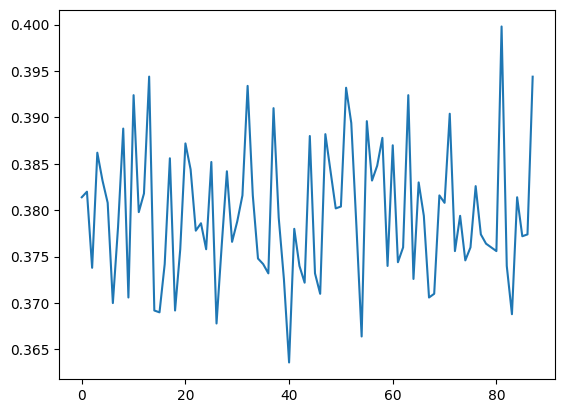

In [199]:
plt.plot(balance)

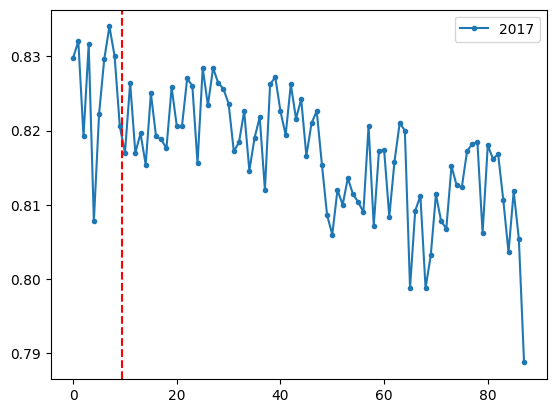

In [200]:
import matplotlib.pyplot as plt
plt.plot(accs, '.-', label='2017')
plt.axvline((features_years[0].shape[0]-train_size)/5000, color='r', linestyle='--')
plt.legend()

# Use drift explorer

In [201]:
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

bool_preprocessor = ColumnTransformer(
transformers=[
    # numerical features : bins + 1-hot
    ('num', Pipeline([
        ('bins', KBinsDiscretizer(n_bins=5, encode='onehot-dense', strategy='uniform')),
        ]), num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categ)], 
    sparse_threshold=0)

In [202]:

import sys
sys.path.append("..")
from divexp import *
from tqdm import tqdm

minsup = 0.05


df_train_unsup = pd.DataFrame(data=bool_preprocessor.fit_transform(df_train_unproc), columns=bool_preprocessor.get_feature_names_out()).astype(bool)

In [203]:

matches = compute_matches(df_train_unsup, minsup=minsup, n_proc=36)

matches_ts_list = []
df_tests = []
from tqdm import tqdm 

batch_size = 5000 
num_iterations = df_test_unproc.shape[0] // batch_size

df_tests_unsup = []
for i in range(num_iterations + 1):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    df_test_i = df_test_unproc[start_idx:end_idx]
    df_test_unsup = pd.DataFrame(bool_preprocessor.transform(df_test_i), columns=bool_preprocessor.get_feature_names_out()).astype(bool)
    matches_ts = compute_matches(df_test_unsup, fi=matches.fi)
    matches_ts_list.append(matches_ts)
    df_tests_unsup.append(df_test_unsup)

In [204]:
y_trues = []
y_preds = []

divs = []

for i in range(num_iterations + 1):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    df_test_prep_i = df_test_prep[start_idx:end_idx]
    y_true_i = labels_test[start_idx:end_idx]
    y_pred_i = xgb_model.predict(df_test_prep_i)

    matches_ts_i = matches_ts_list[i]

    from divexp import Matches
    matches = Matches(matches=matches_ts_i.matches.astype(int), fi=matches_ts_i.fi)


    divs.append(div_explorer(matches, np.array(y_true_i), np.array(y_pred_i), ['accuracy']))

In [217]:
from detect import detect_singlebatch

n_wind = 10
start_win_drift = 70
delta, t_stat = detect_singlebatch(divs, 'accuracy', (0, n_wind), (start_win_drift, n_wind))

In [218]:
df_res = pd.DataFrame(np.vstack([matches.fi.itemsets.values, t_stat.values]).T, columns=['group_ids', 't_stat'])
df_res['group'] = df_res.group_ids.apply(lambda x: [bool_preprocessor.get_feature_names_out()[int(i)] for i in x])
convert = bool_preprocessor.get_feature_names_out().tolist().index
df_res

,group_ids,t_stat,group
0,(10),5.100985,[cat__COW_1.0]
1,(6),4.97462,[num__WKHP_1.0]
2,(754),3.694492,[cat__SEX_1.0]
3,(528),2.140057,[cat__POBP_6.0]
4,(46),5.741744,[cat__MAR_5.0]
...,...,...,...
709,"(0, 5)",1.220873,"[num__AGEP_0.0, num__WKHP_0.0]"
710,"(754, 5)",1.343644,"[cat__SEX_1.0, num__WKHP_0.0]"
711,"(755, 756, 5)",1.653667,"[cat__SEX_2.0, cat__RAC1P_1.0, num__WKHP_0.0]"
712,"(528, 756, 5)",0.313582,"[cat__POBP_6.0, cat__RAC1P_1.0, num__WKHP_0.0]"


In [219]:
df_res.sort_values('t_stat', ascending=False)

,group_ids,t_stat,group
7,(738),6.608088,[cat__RELP_2.0]
217,"(738, 754)",6.514245,"[cat__RELP_2.0, cat__SEX_1.0]"
214,"(738, 10)",6.303188,"[cat__RELP_2.0, cat__COW_1.0]"
232,"(738, 10, 6)",6.188847,"[cat__RELP_2.0, cat__COW_1.0, num__WKHP_1.0]"
122,"(0, 10, 46)",6.065523,"[num__AGEP_0.0, cat__COW_1.0, cat__MAR_5.0]"
...,...,...,...
605,"(737, 42, 756)",0.015694,"[cat__RELP_1.0, cat__MAR_1.0, cat__RAC1P_1.0]"
574,"(737, 756)",0.015694,"[cat__RELP_1.0, cat__RAC1P_1.0]"
440,"(1, 754, 756, 6)",0.01466,"[num__AGEP_1.0, cat__SEX_1.0, cat__RAC1P_1.0, ..."
276,"(10, 42, 754)",0.008713,"[cat__COW_1.0, cat__MAR_1.0, cat__SEX_1.0]"


In [220]:
for d in divs:
    d['accuracy'] = (d['tp'] + d['tn'])/ (d['fp'] + d['fn'] + d['tp'] + d['tn'])

In [221]:
idxs = list(df_res.sort_values('t_stat', ascending=False).index)

In [222]:
divs[0].iloc[217], divs[-1].iloc[217]

(subgroup    (738, 754)
 tp                  12
 tn                 336
 fp                   6
 fn                  22
 accuracy      0.925532
 Name: 217, dtype: object,
 subgroup    (738, 754)
 tp                   5
 tn                  72
 fp                   2
 fn                   5
 accuracy      0.916667
 Name: 217, dtype: object)

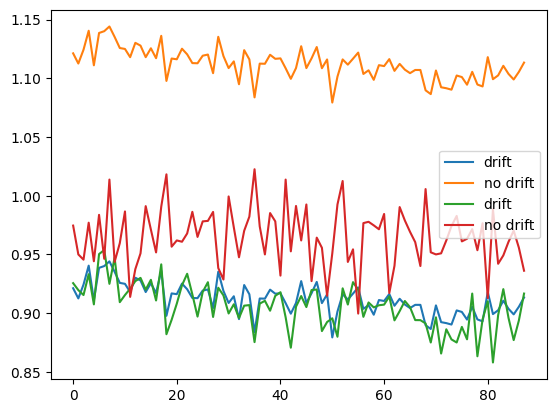

In [223]:
for i in range(2):
    acc2 = [d.iloc[idxs[i]]['accuracy'] for d in divs]
    plt.plot(acc2, label = 'drift')


    acc2 = [d.iloc[idxs[-i]]['accuracy']+0.2 for d in divs]
    plt.plot(acc2, label = 'no drift')

plt.legend()